In [125]:
from disent.systems.vae import VaeSystem
from disent.util import plt_show_grid
import numpy as np
import torch
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt

def plot_sampled(system, num_samples=9):
    samples = []
    for i in range(9):
        while True:
            temp = system.model.decode_from_gaussian_samples(1)
            temp = temp.cpu().detach().numpy()
            temp = np.uint8(temp * 255)
            temp = np.moveaxis(temp.reshape(-1, 3, 64, 64), 1, -1)
            if temp.std() > 100: # std produces smoother results than mean
                samples.append(temp[0])
                break

    # plt_make_subplots_grid(samples, figsize=(10, 10))
    plt_show_grid(samples)

def get_latent_outputs(system, num_samples=1000):
    means, logvars = [], []
    for i, batch in enumerate(DataLoader(system.dataset_train, batch_size=1, shuffle=True)):
        x, _ = batch
        z_mean, z_logvar = system.model.encode_gaussian(x.cuda())
        means.append(z_mean.cpu().detach().numpy()[0])
        logvars.append(z_logvar.cpu().detach().numpy()[0])
        if i >= num_samples:
            break
    means, logvars = np.array(means), np.array(logvars)
    return means, logvars #, np.exp(logvars).mean(axis=0)
    
def plot_system_mean_and_var(system, num_samples=100):
    means, logvars = get_latent_outputs(system, num_samples)
    
    means_mean, means_std = means.mean(axis=0), means.std(axis=0)
    logvars = np.exp(logvars) ** 0.5
    logvar_mean, logvar_std = logvars.mean(axis=0), logvars.std(axis=0)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
    
    ax1.set_title('z_mean')
    ax1.set_xlabel('idx')
    ax1.set_ylabel('value')
    ax1.errorbar(np.arange(len(means_mean)), means_mean, yerr=means_std)

    ax2.set_title('exp(z_logvar) ** 0.5')
    ax2.set_xlabel('idx')
    ax2.set_ylabel('value')
    ax2.errorbar(np.arange(len(logvar_mean)), logvar_mean, yerr=logvar_std)

def train_system(loss='ada-gvae', dataset='3dshapes', model='simple-fc', z_dim=6, epochs=1, save_path=None):
    system = VaeSystem(dataset_train=dataset, model=model, loss=loss, hparams=dict(num_workers=8, batch_size=64, z_dim=z_dim))
    # if load_path:
    #     system.load_from_checkpoint(checkpoint_path=PATH)
    trainer = system.quick_train(epochs=EPOCHS)
    if save_path:
        trainer.save_checkpoint(save_path)
    return system, trainer
    

In [1]:
PATH = 'data/trained-3dshapes-simple-conv-100.ckpt'
system, trainer = train_system(loss='ada-gvae', epochs=33, model='simple-conv', save_path=PATH)

INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name                              | Type                 | Params
-----------------------------------------------------------------------
0  | model                             | GaussianEncoderModel | 3 M   
1  | model.gaussian_encoder            | EncoderSimpleConv64  | 1 M   
2  | model.gaussian_encoder.model      | Sequential           | 1 M   
3  | model.gaussian_encoder.model.0    | Conv2d               | 1 K   
4  | model.gaussian_encoder.model.1    | ReLU                 | 0     
5  | model.gaussian_encoder.model.2    | Conv2d               | 16 K  
6  | model.gaussian_encoder.model.3    | ReLU                 | 0     
7  | model.gaussian_encoder.model.4    | Conv2d               | 32 K  
8  | model.gaussian_encoder.model.5    | ReLU                 | 0     
9  | model.gaussian_encoder.model.6    | Conv2d               | 131 K 
10 | model.gaussian_encoder.model.7    | ReLU        

/home/nmichlo/.pyenv/versions/miniconda3-latest/envs/disentangle/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:18: RuntimeWarning: Displayed epoch numbers in the progress bar start from "1" until v0.6.x, but will start from "0" in v0.8.0.
  warnings.warn(*args, **kwargs)


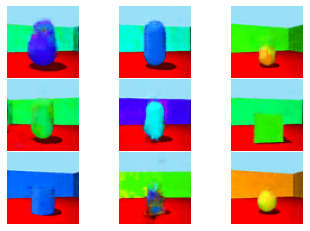

In [120]:
plot_sampled(system, 9)

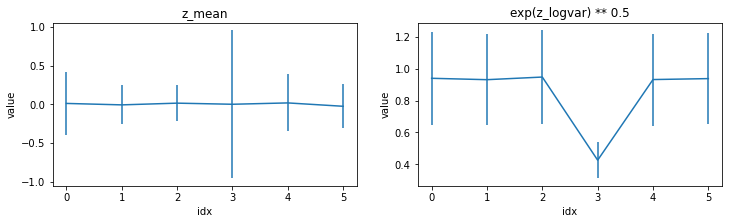

In [113]:
    
plot_system_mean_and_var(system, 10000)

## MINI TESTS

In [ ]:
fc_system, fc_trainer = train_system(loss='ada-gvae', z_dim=6, epochs=1)
plot_sampled(fc_system, 9)
plot_system_mean_and_var(fc_system, 10000)

INFO:lightning:GPU available: True, used: True
INFO:lightning:VISIBLE GPUS: 0
INFO:lightning:
   | Name                              | Type                 | Params
-----------------------------------------------------------------------
0  | model                             | GaussianEncoderModel | 6 M   
1  | model.gaussian_encoder            | EncoderSimpleFC      | 3 M   
2  | model.gaussian_encoder.model      | Sequential           | 3 M   
3  | model.gaussian_encoder.model.0    | Flatten3D            | 0     
4  | model.gaussian_encoder.model.1    | Linear               | 3 M   
5  | model.gaussian_encoder.model.2    | ReLU                 | 0     
6  | model.gaussian_encoder.model.3    | Linear               | 32 K  
7  | model.gaussian_encoder.model.4    | ReLU                 | 0     
8  | model.gaussian_encoder.enc3mean   | Linear               | 774   
9  | model.gaussian_encoder.enc3logvar | Linear               | 774   
10 | model.decoder                     | DecoderSimpl

In [ ]:
fc_system, fc_trainer = train_system(loss='ada-gvae', z_dim=3, epochs=1)
plot_sampled(fc_system, 9)
plot_system_mean_and_var(fc_system, 10000)